## Get 10km square polygons around ushcn sites

loosely based on this method: https://www.neonscience.org/field-data-polygons-centroids

In [1]:
library(readr)
library(sp)
library(rgdal)

rgdal: version: 1.4-7, (SVN revision 845)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.4.3, released 2019/10/28
 Path to GDAL shared files: /usr/share/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 6.2.1, November 1st, 2019, [PJ_VERSION: 620]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.3-1 


In [2]:
source('common_stats_functions.r')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



OGR data source with driver: ESRI Shapefile 
Source: "/home/greg/data/GD_gregmaurer/droughtnet_precipsens_data/NEONdomains", layer: "NEON_Domains"
with 22 features
It has 6 fields


Regions defined for each Polygons


In [3]:
setwd(paste0(dn_path, 'USHCN_derived/'))
ushcn_data <- read_csv('allyr_ushcn_calcs_allstations.csv')

Parsed with column specification:
cols(
  .default = col_double(),
  stationid = col_character(),
  elev = col_character(),
  state = col_character(),
  name = col_character(),
  flag1 = col_character(),
  flag2 = col_character(),
  flag3 = col_character()
)
See spec(...) for full column specifications.


In [5]:
# translated to R from this SO answer: https://stackoverflow.com/a/238558M

# degrees to radians
deg2rad <- function(degrees){
    return(pi*degrees/180.0)
}
# radians to degrees
rad2deg <- function(radians){
    return(180.0*radians/pi)
    }

# Semi-axes of WGS-84 geoidal reference
WGS84_a <- 6378137.0  # Major semiaxis [m]
WGS84_b <- 6356752.3  # Minor semiaxis [m]

# Earth radius at a given latitude, according to the WGS-84 ellipsoid [m]
WGS84EarthRadius <- function(lat){
    # http://en.wikipedia.org/wiki/Earth_radius
    An <- WGS84_a*WGS84_a * cos(lat)
    Bn <- WGS84_b*WGS84_b * sin(lat)
    Ad <- WGS84_a * cos(lat)
    Bd <- WGS84_b * sin(lat)
    return(sqrt( (An*An + Bn*Bn)/(Ad*Ad + Bd*Bd) ))
    }

# Bounding box surrounding the point at given coordinates,
# assuming local approximation of Earth surface as a sphere
# of radius given by WGS84
boundingBox <- function(latitudeInDegrees, longitudeInDegrees, halfSideInKm){
    lat <- deg2rad(latitudeInDegrees)
    lon <- deg2rad(longitudeInDegrees)
    halfSide <- 1000*halfSideInKm

    # Radius of Earth at given latitude
    radius <- WGS84EarthRadius(lat)
    # Radius of the parallel at given latitude
    pradius <- radius*cos(lat)

    latMin <- lat - halfSide/radius
    latMax <- lat + halfSide/radius
    lonMin <- lon - halfSide/pradius
    lonMax <- lon + halfSide/pradius

    return(list(rad2deg(latMin), rad2deg(lonMin), rad2deg(latMax), rad2deg(lonMax)))
}

In [6]:
# set the radius for the plots
radius <- 5 # radius in km (should make 10km box)

ans <- boundingBox(ushcn_data$latitude, ushcn_data$longitude, radius)

# define the plot edges based upon the plot radius. 

yPlus <- ans[[3]]  #ushcn_data$latitude+radius
xPlus <- ans[[4]]  #ushcn_data$longitude+radius
yMinus <- ans[[1]] #ushcn_data$latitude-radius
xMinus <- ans[[2]] #ushcn_data$longitude-radius

In [7]:
# calculate polygon coordinates for each plot centroid. 
square=cbind(xMinus,yPlus,  # NW corner
    xPlus, yPlus,  # NE corner
    xPlus,yMinus,  # SE corner
    xMinus,yMinus, # SW corner
    xMinus,yPlus)  # NW corner again - close ploygon

In [8]:
# Extract the plot ID information
ID=ushcn_data$stationid

In [9]:
proj4string = CRS("+proj=longlat +ellps=WGS84 +datum=WGS84")
proj4string

CRS arguments:
 +proj=longlat +ellps=WGS84 +datum=WGS84 +towgs84=0,0,0 

In [10]:
# create spatial polygons from coordinates
polys <- SpatialPolygons(mapply(function(poly, id) 
        {
      xy <- matrix(poly, ncol=2, byrow=TRUE)
      Polygons(list(Polygon(xy)), ID=id)
      }, 
    split(square, row(square)), ID),
    proj4string=CRS(as.character("+proj=longlat +ellps=WGS84 +datum=WGS84")))

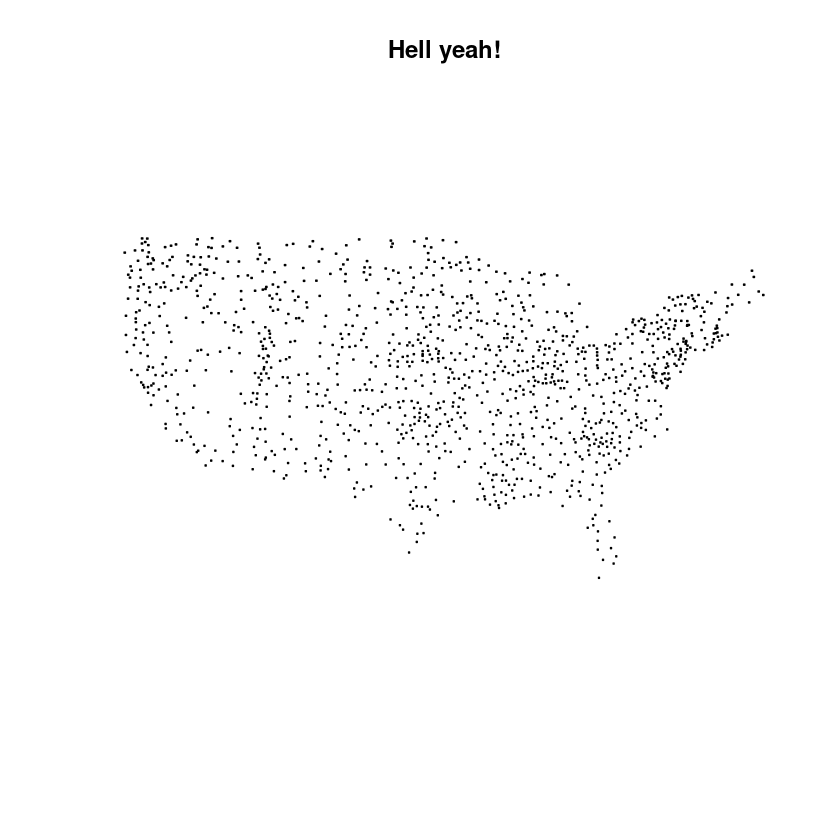

In [11]:
# plot the new polygons
plot(polys, main='Hell yeah!')

In [12]:
# Create SpatialPolygonDataFrame -- this step is required to output multiple polygons.
polys.df <- SpatialPolygonsDataFrame(polys, data.frame(id=ID, row.names=ID))


In [13]:
dim(polys.df)

[1] 1218    1

In [14]:
# write the shapefiles 
writeOGR(polys.df, '.', 'USHCN_10km_polygons', 'ESRI Shapefile')

ERROR: Error in writeOGR(polys.df, ".", "USHCN_10km_polygons", "ESRI Shapefile"): layer exists, use a new layer name
